Project Title: Classifying Wellness HuffPost News Using DistilBERT-base-uncased Transformer Models with Unigram vs. Bigram <br>
Date: 2024 Jan 26 <br>
Author: Tsai-Yun Li <br>
Course Lecturer: Chris J. Vargo and Scott Bradley <br>
Course: Supervised Text Classification for Marketing Analysis <br>
Organization: University of Colorado Boulder <br>
Dataset (provided in the course): News Headlines from HuffPost <br>
GitHub Repository Link: https://github.com/TsaiYunLi/TextMA1_FinalProj_TsaiYunLi <br>
Google Colab Link: https://drive.google.com/file/d/1h0qX9ohXb0WrDnr1JUIru5dwXmxGngzc/view?usp=sharing

## Table of Contents

1. Problem Description
2. Data Description
3. Exploratory Data Analysis (EDA)
4. Data Preparation
5. Model Training and Evaluation
<br> 5.1 DistilBERT-base-uncased Transformer Model with Unigram
<br> 5.2 DistilBERT-base-uncased Transformer Model with Bigram
6. Discussion and Conclusion
7. Refernces

## 1. Problem Description
In an imaged scenario, I am working for a media buying company,  Chrishare, whose goal is to help their new client, Theragun, to conduct contextual advertising by placing Theragun's ads on web pages of news about wellness, since Theragun have already found out that those who value wellness are their potential customers.

As an NLP engineer in the company, my task is to build a deep learning algorithm to predict the probability that a news story is about wellness. I have got a labelled training dataset (see section 2 for details), so a supervised machine learning approach suits this task. Since my company gives me limited computational resources, I will use the k-train library, a lightweight wrapper for Tensorflow, Keras, and Huggingface Transformers, as well as the transformer model "distillbert," which inherited the training regime and architecture from BERT in a a distilled version, striking a balance between speed and performance, to process the text data and train my final models. To tell to what degree of contextual information is necessary, I will train two models:
model1, a DistilBERT-base-uncased transformer model with unigram only, and model2, a DistilBERT-base-uncased transformer model with bigram only. The two models will be evaluated in terms of their validation datasets' precision, recall, and f1-score for the positive class. Finally, the model with the best performance will be chosen to demo to our customer, Theragun.

## 2. Data Description
The labelled trainig dataset I got from my company was collected from the online HuffPost news from the year 2012 to 2018. It contains around 200k news headlines, their category labels, as well as information about these news article's authors, link, released date, and a short description of their content.

In [1]:
# importing libraries
import os
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np

In [2]:
# updating ktrain
!pip install --upgrade ktrain --user

In [3]:
# checking variable options for the parameters in ktrain
help(ktrain.text.texts_from_df)

Help on function texts_from_df in module ktrain.text.data:

texts_from_df(train_df, text_column, label_columns=[], val_df=None, max_features=20000, maxlen=400, val_pct=0.1, ngram_range=1, preprocess_mode='standard', lang=None, is_regression=False, random_state=None, verbose=1)
    ```
    Loads text data from Pandas dataframe file. Class labels are assumed to be
    one of the following formats:
        1. one-hot-encoded or multi-hot-encoded arrays representing classes:
              Example with label_columns=['positive', 'negative'] and text_column='text':
                text|positive|negative
                I like this movie.|1|0
                I hated this movie.|0|1
            Classification will have a single one in each row: [[1,0,0], [0,1,0]]]
            Multi-label classification will have one more ones in each row: [[1,1,0], [0,1,1]]
        2. labels are in a single column of string or integer values representing class labels
               Example with label_columns=[

Since the preprocess_mode (str) only has the options 'standard,' 'bert,' and 'distilbert,' the model distilroberta-base cannot be applied here. Thus, I did not consider building a distilroberta model for this project.

In [4]:
# monting my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# loading the complete training dataset
news = pd.read_json("drive/MyDrive/news_category_trainingdata.json")

## 3. Exploratory Data Analysis (EDA)

In [6]:
# inspecting a few rows of the complete training dataset
news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [7]:
# adding a new column combining the headline and short_description of each news
news['combined_text'] = news['headline'] + ' ' + news['short_description']

In [8]:
# getting a list of the unique categories in this dataset
unique_categories = news['category'].unique()
print(unique_categories)

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE'
 'WEDDINGS' 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']


There is not a category called 'health and wellness' but 'wellness' in the dataset; thus, I went for the latter.

In [9]:
# returning a subset where the 'category' column contains the string 'WELLNESS'
news[news['category'].str.contains('WELLNESS')]

,category,headline,authors,link,short_description,date,combined_text
124989,WELLNESS,Why Overeating Doesn't Make You Fat,"Mark Hyman, MD, Contributor\nPracticing Physician",https://www.huffingtonpost.com/entry/overeatin...,If you take the right approach to ending your ...,2014-04-17,Why Overeating Doesn't Make You Fat If you tak...
124990,WELLNESS,14 Habits Of People With A Healthy Relationshi...,Sarah Klein,https://www.huffingtonpost.com/entry/healthy-r...,After a long list of rules and habits like the...,2014-04-17,14 Habits Of People With A Healthy Relationshi...
124993,WELLNESS,5 Things That Could Be Stealing Your Joy,"Amanda Gore, Contributor\nInternational keynot...",https://www.huffingtonpost.com/entry/joy_us_5b...,Listen to yourself all day today -- are you an...,2014-04-17,5 Things That Could Be Stealing Your Joy Liste...
124994,WELLNESS,Moments Make a Life,"Megan McDonough, Contributor\nCEO, Wholebeing ...",https://www.huffingtonpost.com/entry/moments-m...,Consciously constructing positive habits -- or...,2014-04-17,Moments Make a Life Consciously constructing p...
124996,WELLNESS,Fat Facts,"Maria Rodale, Contributor\nCEO and Chairman of...",https://www.huffingtonpost.com/entry/fat-facts...,"Human fat cells, photo by Dr. Peeke Here's how...",2014-04-17,"Fat Facts Human fat cells, photo by Dr. Peeke ..."
...,...,...,...,...,...,...,...
200797,WELLNESS,Shoveling Snow? How to Protect Your Back (And ...,,https://www.huffingtonpost.com/entry/shovel-sn...,"Work up to it. Warm up inside, and incorporate...",2012-01-28,Shoveling Snow? How to Protect Your Back (And ...
200799,WELLNESS,7 Reasons Working Too Much Is Bad For Your Health,Sarah Klein,https://www.huffingtonpost.com/entry/overtime-...,"If you're the last one to leave the office, or...",2012-01-28,7 Reasons Working Too Much Is Bad For Your Hea...
200800,WELLNESS,The Sleep Library: 11 Soothing Books For Bedtime,,https://www.huffingtonpost.comhttp://www.oprah...,Do you toss and turn until you finally sit up ...,2012-01-28,The Sleep Library: 11 Soothing Books For Bedti...
200802,WELLNESS,The Benefits of Caring for a Pet,"Rita Altman, R.N., Contributor\nSenior Vice Pr...",https://www.huffingtonpost.com/entry/pets-seni...,"For the young as well as the old, especially i...",2012-01-28,The Benefits of Caring for a Pet For the young...


In [10]:
# adding a column to store the one-hot encoding for the 'category' column that contains the string 'WELLNESS'
news['wellness'] = np.where((news['category'] == 'WELLNESS'), 1, 0)

In [11]:
# checking for data balance
news['wellness'].describe()

count    200853.000000
mean          0.088756
std           0.284393
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wellness, dtype: float64

The news dataset only contains about 8.9% of news with category 'wellness,' indicating a strong imbalance.

## 4. Data Preparation

In [12]:
# sampling to obtain a balanced dataset
sample_amount =  len(news[news['wellness'] == 1]) # the total number of wellness articles
wellness = news[news['wellness'] == 1].sample(n=sample_amount)
not_wellness = news[news['wellness'] == 0].sample(n=sample_amount)

In [13]:
# creating a balanced dataset to include the same number of wellness and not_wellness news
news_balanced_dataset = pd.concat([wellness,not_wellness])

In [14]:
# double checking databalance
news_balanced_dataset.describe()

,wellness
count,35654.000000
mean,0.500000
std,0.500007
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


Now, the news_balanced_dataset is perfectly balanced, containing 50% wellness news and 50% not_wellness news, 17827 for each.

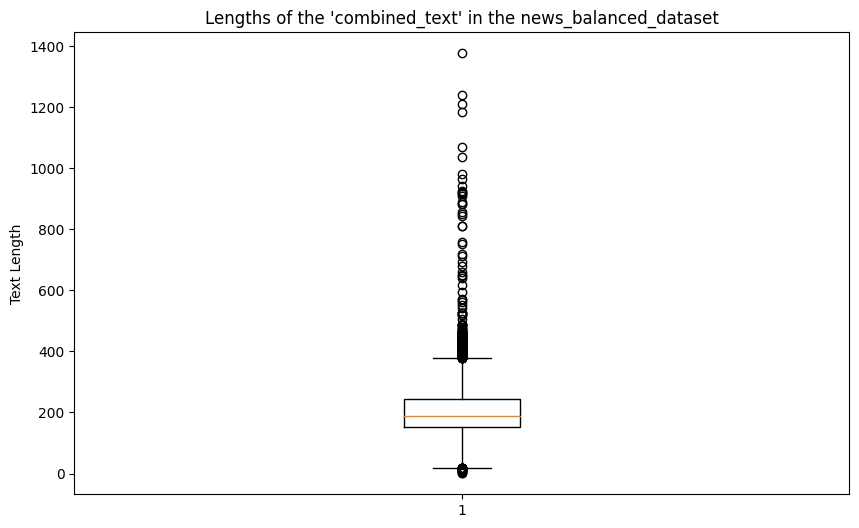

In [15]:
# visualizing the lengths of the 'combined_text' in the news_balanced_dataset
# with a box plot
import matplotlib.pyplot as plt

news_balanced_dataset['text_length'] = news_balanced_dataset['combined_text'].apply(len)

plt.figure(figsize=(10, 6))
plt.boxplot(news_balanced_dataset['text_length'])
plt.title("Lengths of the 'combined_text' in the news_balanced_dataset")
plt.ylabel('Text Length')
plt.show()

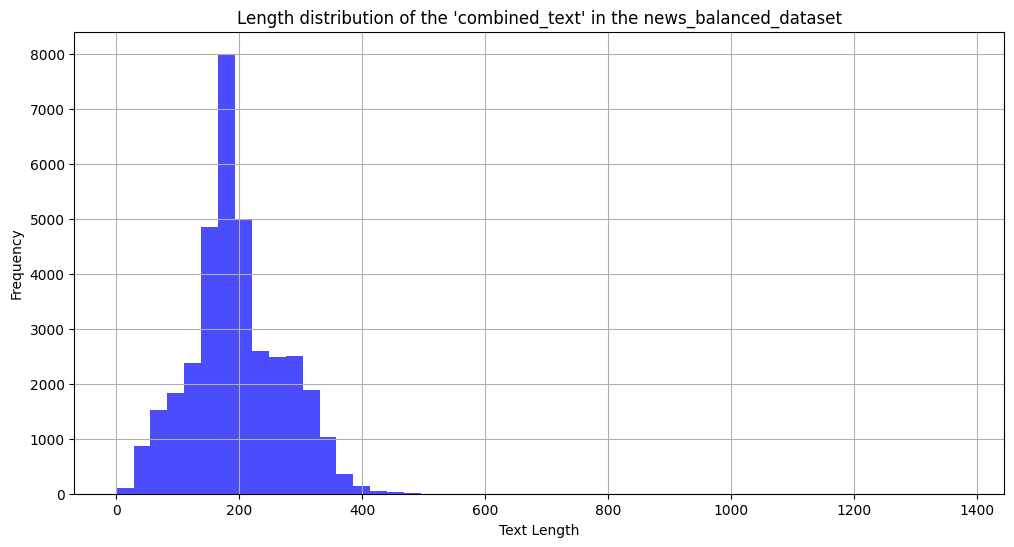

In [16]:
# visualizing the length distribution of the 'combined_text' in the news_balanced_dataset
# with a histogram
plt.figure(figsize=(12, 6))
plt.hist(news_balanced_dataset['text_length'], bins=50, color='blue', alpha=0.7)
plt.title("Length distribution of the 'combined_text' in the news_balanced_dataset")
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
# getting the max length of the 'combined_text' in the news_balanced_dataset
max_length = news_balanced_dataset['text_length'].max()
print("The maximum length of the 'combined_text' in the news_balanced_dataset is:", max_length)

The maximum length of the 'combined_text' in the news_balanced_dataset is: 1376


In [18]:
# getting a percentile report on the length of the 'combined_text' in the news_balanced_dataset
percentiles = news_balanced_dataset['text_length'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("Percentile Report:")
print(percentiles)

Percentile Report:
0.25    154.0
0.50    187.0
0.75    244.0
0.90    303.0
0.95    328.0
0.99    376.0
Name: text_length, dtype: float64


In terms of the text lengths in 'combined_text', it turns out that about 1% of the news (35654*1%=366) in the news_balanced_dataset are outliers, with 1376 words the longest. Nevertheless, since a balanced dataset is healthy for training models to identify and predict wellness news, I decided not to remove these outliers. Instead, I will use a max length of 400, which captures 99% of the data, to truncate the 'combined_text' when training the models (see section 5.1 and 5.2).

## 5. Model Training and Evaluation

### 5.1 DistilBERT-base-uncased Transformer Model with Unigram

In [19]:
train1, val1, preprocess1 = ktrain.text.texts_from_df(
    news_balanced_dataset,
    'combined_text',
    label_columns=['wellness'], #
    val_df=None,
    max_features=20000,
    maxlen=400, #
    val_pct=0.1,
    ngram_range=(1,1), #
    preprocess_mode="distilbert",
    verbose=1
)

['not_wellness', 'wellness']
        not_wellness  wellness
149801           1.0       0.0
24577            1.0       0.0
19633            1.0       0.0
55551            1.0       0.0
144179           0.0       1.0
['not_wellness', 'wellness']
        not_wellness  wellness
184895           0.0       1.0
119159           1.0       0.0
161368           0.0       1.0
128829           0.0       1.0
64605            1.0       0.0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 34
	95percentile : 58
	99percentile : 67


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 34
	95percentile : 58
	99percentile : 68


In [20]:
model1 = preprocess1.get_classifier()
learner1 = ktrain.get_learner(model1, train_data=train1, val_data=val1, batch_size=16)

In [21]:
learner1.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
2005/2005 [==============================] - 1362s 669ms/step - loss: 0.4325 - accuracy: 0.7825
Epoch 2/3
2005/2005 [==============================] - 1338s 667ms/step - loss: 0.5632 - accuracy: 0.6427
Epoch 3/3
2005/2005 [==============================] - 1316s 657ms/step - loss: 0.7829 - accuracy: 0.5001


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


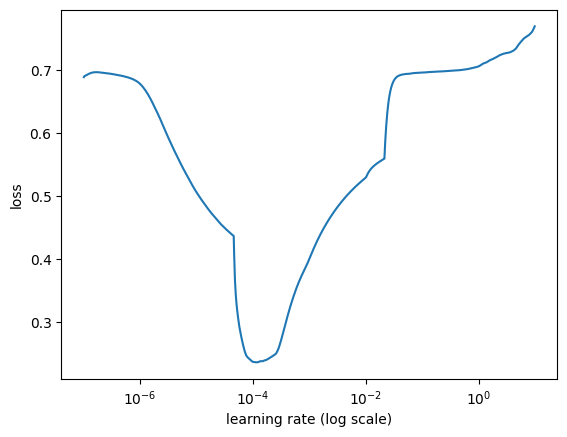

In [22]:
learner1.lr_plot()

In [24]:
history1 = learner1.autofit(
    1e-5, #
    checkpoint_folder='checkpoint',
    epochs=3, #
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/3
2006/2006 [==============================] - 1395s 690ms/step - loss: 0.2324 - accuracy: 0.9116 - val_loss: 0.1817 - val_accuracy: 0.9313
Epoch 2/3
2006/2006 [==============================] - 1379s 688ms/step - loss: 0.1565 - accuracy: 0.9436 - val_loss: 0.1742 - val_accuracy: 0.9344
Epoch 3/3
2006/2006 [==============================] - 1375s 685ms/step - loss: 0.1245 - accuracy: 0.9573 - val_loss: 0.1814 - val_accuracy: 0.9361
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


In [25]:
predictor1 = ktrain.get_predictor(learner1.model, preproc=preprocess1)

In [26]:
validation1 = learner1.validate(val_data=val1, print_report=True)

112/112 [==============================] - 38s 324ms/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1838
           1       0.92      0.95      0.93      1728

    accuracy                           0.93      3566
   macro avg       0.93      0.93      0.93      3566
weighted avg       0.94      0.93      0.93      3566



### 5.2 DistilBERT-base-uncased Transformer Model with Bigram

In [27]:
train2, val2, preprocess2 = ktrain.text.texts_from_df(
    news_balanced_dataset,
    'combined_text',
    label_columns=['wellness'], #
    val_df=None,
    max_features=20000,
    maxlen=400, #
    val_pct=0.1,
    ngram_range=(2,2), #
    preprocess_mode="distilbert",
    verbose=1
)

['not_wellness', 'wellness']
        not_wellness  wellness
71612            1.0       0.0
183965           0.0       1.0
184696           0.0       1.0
181271           0.0       1.0
155362           1.0       0.0
['not_wellness', 'wellness']
        not_wellness  wellness
164938           0.0       1.0
134491           1.0       0.0
67718            1.0       0.0
121064           1.0       0.0
108369           1.0       0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 34
	95percentile : 58
	99percentile : 67


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 34
	95percentile : 59
	99percentile : 68


In [28]:
model2 = preprocess2.get_classifier()
learner2 = ktrain.get_learner(model2, train_data=train2, val_data=val2, batch_size=16)

In [29]:
learner2.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
2005/2005 [==============================] - 1354s 667ms/step - loss: 0.3954 - accuracy: 0.8324
Epoch 2/3
2005/2005 [==============================] - 1338s 668ms/step - loss: 0.5261 - accuracy: 0.7148
Epoch 3/3
2005/2005 [==============================] - 1304s 651ms/step - loss: 0.8082 - accuracy: 0.5013


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


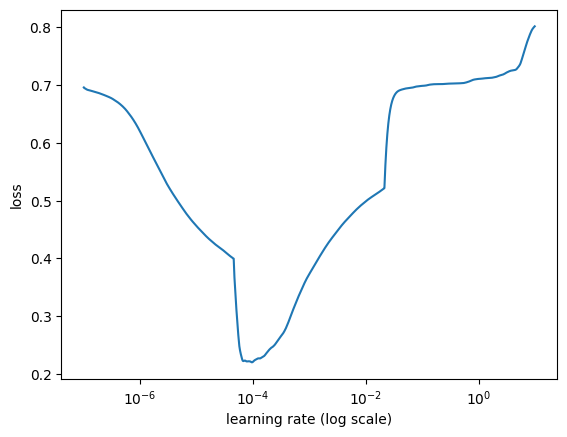

In [30]:
learner2.lr_plot()

In [31]:
history2 = learner2.autofit(
    1e-5, #
    checkpoint_folder='checkpoint',
    epochs=3, #
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/3
2006/2006 [==============================] - 1384s 682ms/step - loss: 0.2450 - accuracy: 0.9042 - val_loss: 0.1835 - val_accuracy: 0.9321
Epoch 2/3
2006/2006 [==============================] - 1384s 690ms/step - loss: 0.1568 - accuracy: 0.9443 - val_loss: 0.1803 - val_accuracy: 0.9341
Epoch 3/3
2006/2006 [==============================] - 1378s 687ms/step - loss: 0.1220 - accuracy: 0.9589 - val_loss: 0.1895 - val_accuracy: 0.9335
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


In [32]:
predictor2 = ktrain.get_predictor(learner2.model, preproc=preprocess2)

In [33]:
validation2 = learner2.validate(val_data=val2, print_report=True)

112/112 [==============================] - 30s 252ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1775
           1       0.93      0.94      0.93      1791

    accuracy                           0.93      3566
   macro avg       0.93      0.93      0.93      3566
weighted avg       0.93      0.93      0.93      3566



## 6. Discussion and Conclusion

In [37]:
# comparing performance metrics for class 1 on the two models' validation dataset:
model1_metrics = {'precision': 0.92, 'recall': 0.95, 'f1-score': 0.93}
model2_metrics = {'precision': 0.93, 'recall': 0.94 , 'f1-score': 0.93}

comparison_df = pd.DataFrame({
    'Model': ['Model1: DistilBERT-base-uncased Unigram', 'Model2: DistilBERT-base-uncased Bigram'],
    'Class 1 Precision': [model1_metrics['precision'], model2_metrics['precision']],
    'Class 1 Recall': [model1_metrics['recall'], model2_metrics['recall']],
    'Class 1 F1-Score': [model1_metrics['f1-score'], model2_metrics['f1-score']]
})
comparison_df

,Model,Class 1 Precision,Class 1 Recall,Class 1 F1-Score
0,Model1: DistilBERT-base-uncased Unigram,0.92,0.95,0.93
1,Model2: DistilBERT-base-uncased Bigram,0.93,0.94,0.93


1. Some Notes on the Models' Hyperparameters: <br>

Compared with the lab assignment we've done, the hyperparameters I tweaked in this project are maxlen, ngram_range, and the number of epochs during model training and fitting the best learning rate to the model (marked with a "#"). I used the 99% text length as the value for maxlen (see section 4 for visualizations and detailed explanation). I also experimented with the number of epochs for model training, starting from epoch=6, and found out that the elbow sweet point occured within 3 epochs. Therefore, to save run time, its epoch number is set to 3. As for the number of epochs for fitting the best learning rate, I cut it down to 3 to shorten the run time without any good reasoning (see more in limitations). The hyperparameters of the two models only differ in their ngram_rage. Model 1 uses unigrams only, with ngram_rage=(1,1); while, model 2 uses bigrams only, with ngram_rage=(2,2).

2. Model Performance Evaluation Results and Conclusion:  <br>

Since our goal is to place Theragun's add in as many wellness news web page as possible and that a few misplacements would not do much harm, among all the metrics, we value 'recall' most. The model with a higher recall (0.95) for the positive class is model1, DistilBERT-base-uncased transformer model using unigrams only. Model2, which uses bigrams, probably introduced sparsity that lowered its recall a little bit (0.94). It turns out that unigram captures enough contextual information for the model. Nevertheless, the two models both perform pretty well, with very close precision, recall, and f1-score values on their validation sets. In conclusion, to pick out the best model for the task described in section 1, model 1, DistilBERT-base-uncased transformer model with unigram (positive class recall=0.95) is most suitable.

3. Limiataions: <br>

There are quite some limitations in this project. First of all, due to limited GPU avaliable in this free Google Colab, larger transformer models like BERT or RoBERTa and complexer libraries beside ktrain are hard to implement. The ktrain library also limit the choice of transformer model to 'standard,' 'bert,' and 'distilbert,' making distilRoBERTa-base unavailiable. It would be interesting to compare a distilRoBERTa-base solution to the distilBERT-base-uncased ones built in this project. Secondly, to avoid crazy long run time (run time for 3 epochs already took more than an hour), I had to cut the epoch number for learning-rate-fitting to 3, not waiting till an early stop before the models starting to overfit. This can potentially lower the performance of the models. These limitations could possibly be lifted if I had access to more computational resources, which could speed up model training run time.



## 7. References
Code Built on: "Coding Lab 2: Building a Model with K-Train," provided in the course <br>
Data Source: HuffPost, provided in the course as "news_category_trainingdata.json" <br>
Transformer Models Source: https://huggingface.co/models <br>
DistilBERT-base-uncased Transformer Model: https://huggingface.co/distilbert-base-uncased <br>
DistilRoBERTa-base Transformer Model: https://huggingface.co/distilroberta-base <br>
ngram_range: https://medium.com/analytics-vidhya/introduction-to-text-classification-in-python-659eccf6b2e#:~:text=The%20simplest%20definition%20for%20'n,be%20extracted%20from%20the%20corpus.